In [1]:
import numpy as np
import keras
from google.colab import drive
from gensim.models import Word2Vec
import os
from bs4 import BeautifulSoup 
import json
import ast
import tensorflow as tf
import pickle

In [2]:
SAVE_FILE = "drive/MyDrive/Studium/projekt/data/data_prepare_final.pkl"
SAVE_TOKEN_2_KEY =  "drive/MyDrive/Studium/projekt/data/token_2_key.json"
SAVE_KEY_2_TOKEN =  "drive/MyDrive/Studium/projekt/data/key_2_token.json"
SAVE_MODEL_ONE_HOT = "drive/MyDrive/Studium/projekt/data/one_hot_encoder.pkl"

END_OF_SENTENCE_TAG = "//S"
LOOK_UP = 10

#### Laden der Daten

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
with open(SAVE_FILE, 'rb') as file: 
    data = pickle.load(file)

In [5]:
#load dict to transform key to token and back
f = open(SAVE_KEY_2_TOKEN)
key_2_token = json.load(f)

f = open(SAVE_TOKEN_2_KEY)
token_2_key = json.load(f)

In [6]:
#load one_hot encoding model
one_hot_encoder = pickle.load(open(SAVE_MODEL_ONE_HOT, 'rb'))

In [7]:
data.keys()

dict_keys(['X_train_text', 'X_train_relations', 'X_train_agent_patient', 'y_train', 'X_test_text', 'X_test_relations', 'X_test_agent_patient', 'y_test', 'x_data', 'org_text'])

In [8]:
#train data
X_train_text = np.array(data["X_train_text"])
X_train_relations = np.array(data["X_train_relations"])
X_train_agent_patient = np.array(data["X_train_agent_patient"])
y_train = np.array(data["y_train"])


#test data
X_test_text = np.array(data["X_test_text"])
X_test_relations = np.array(data["X_test_relations"])
X_test_agent_patient = np.array(data["X_test_agent_patient"])
y_test = np.array(data["y_test"])
org_text_test = np.array(data["org_text"])

In [9]:
X_test_text.shape

(500, 10, 355)

#### Modell anlegen

In [10]:
INPUT_SHAPE_TEXT = X_train_text.shape[1:]
INPUT_SHAPE_RELATIONS = X_test_relations.shape[1:]
INPUT_AGENT_PATIENT = X_train_agent_patient.shape[1:]

OUTPUT_SHAPE = y_train.shape[1]

In [11]:
INPUT_SHAPE_TEXT

(10, 355)

In [12]:
input_relations = keras.layers.Input(shape=INPUT_SHAPE_RELATIONS)
relations = keras.layers.Flatten()(input_relations)

input_agent_patient = keras.layers.Input(shape=INPUT_AGENT_PATIENT)
agent_patient = keras.layers.Flatten()(input_agent_patient)

input_text = keras.layers.Input(shape=INPUT_SHAPE_TEXT)
rnn = keras.layers.Attention(80)([input_text,input_text])
x = keras.layers.Dense(80)(rnn)
x = keras.layers.Flatten()(x)

x = keras.layers.Concatenate()([x,relations,agent_patient])
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(700,activation='relu')(x)
x = keras.layers.Dense(400,activation='relu')(x)
output = keras.layers.Dense(OUTPUT_SHAPE,activation='softmax')(x)

In [13]:
model = keras.Model([input_relations,input_text,input_agent_patient], output)
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["accuracy"] )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10, 355)]    0           []                               
                                                                                                  
 attention (Attention)          (None, 10, 355)      1           ['input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 10, 80)       28480       ['attention[0][0]']              
                                                                                                  
 input_1 (InputLayer)           [(None, 3, 25)]      0           []                           

In [14]:
split =  370
X_train_relations = np.concatenate([X_train_relations,X_test_relations[0:split]])
X_train_text = np.concatenate([X_train_text,X_test_text[0:split]])
X_train_agent_patient = np.concatenate([X_train_agent_patient,X_test_agent_patient[0:split]])
y_train = np.concatenate([y_train,y_test[0:split]])

#### Modell trainieren

In [15]:
history = model.fit([X_train_relations,X_train_text,X_train_agent_patient],y_train,epochs=61,validation_data=([X_test_relations,X_test_text,X_test_agent_patient],y_test))

Epoch 1/61
1325/1325 [==============================] - 9s 6ms/step - loss: 2.9420 - accuracy: 0.3670 - val_loss: 2.3544 - val_accuracy: 0.4380
Epoch 2/61
1325/1325 [==============================] - 5s 4ms/step - loss: 1.9863 - accuracy: 0.5034 - val_loss: 1.6910 - val_accuracy: 0.5880
Epoch 3/61
1325/1325 [==============================] - 5s 4ms/step - loss: 1.5379 - accuracy: 0.5853 - val_loss: 1.4192 - val_accuracy: 0.6420
Epoch 4/61
1325/1325 [==============================] - 5s 4ms/step - loss: 1.3112 - accuracy: 0.6341 - val_loss: 1.2670 - val_accuracy: 0.6820
Epoch 5/61
1325/1325 [==============================] - 5s 4ms/step - loss: 1.1604 - accuracy: 0.6637 - val_loss: 1.1682 - val_accuracy: 0.6940
Epoch 6/61
1325/1325 [==============================] - 6s 4ms/step - loss: 1.0493 - accuracy: 0.6896 - val_loss: 1.0608 - val_accuracy: 0.7280
Epoch 7/61
1325/1325 [==============================] - 6s 4ms/step - loss: 0.9612 - accuracy: 0.7112 - val_loss: 1.0131 - val_accuracy:

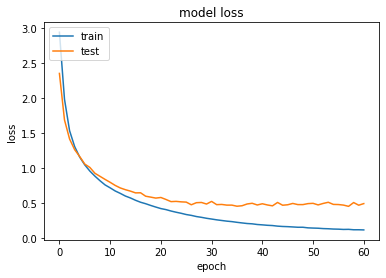

In [16]:
# summarize history for loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

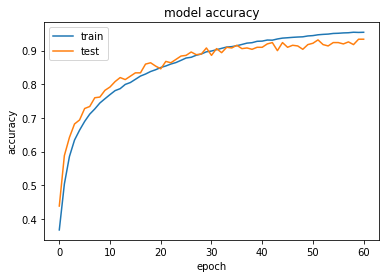

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model predict

In [18]:
y_pred = model.predict([X_test_relations,X_test_text,X_test_agent_patient])

In [19]:
#vorbereiten text
def preprare_text(text):
  result = []
  for token in text:
    token_one_hot = [0]*(len(token_2_key)-1)
    if token == "-1":
      token_one_hot[token_2_key[str(token)]-1] = 1
    else:
      token_one_hot[token_2_key[str(token)]] = 1
    result.append(token_one_hot)
  return np.array([result[-LOOK_UP:]])

#get relations
def get_relations(relations_one_hot):
  relations = []
  for one_hot in relations_one_hot:
    relations.append(one_hot_encoder.inverse_transform(one_hot))
  
  return [r[0] for r in relations[0]]

In [20]:
for i in range(len(X_test_agent_patient)-1):
  if hash(str(X_test_agent_patient[i])) != hash(str(X_test_agent_patient[i+1])):
    agent_patient = X_test_agent_patient[i:i+1]
    relations = X_test_relations[i:i+1]

    j = 0
    text = ["-1"]*LOOK_UP
    while text[-1:][0] != END_OF_SENTENCE_TAG and j < 100:
      text_prepare = preprare_text(text)
      pred = model.predict([relations,text_prepare,agent_patient])
      #print(key_2_token[str(np.argmax(pred))])
      text.append(key_2_token[str(np.argmax(pred))])
      j+=1
    print("".join(text[LOOK_UP:]))
    print(org_text_test[i])
    print(get_relations(relations))
    print()

agent1//wist//wmit//wpatient1seiten//wbedruckt//wund//what//weine//wisbnnummer//wvon//wpatient3.//w//S
[<text>Das Buch "Alcatraz Versus the Evil Librarians" ist mit 320 Seiten gedruckt und hat eine ISBN-Nummer von 0-439-92550-9. </text>]
[' numberOfPages ', ' ISBN_number ', None]

agent1//wkann//win//wpatient1//wveröffentlicht.//w//S
[<text>Ein Loyal Character Dancer wurde in Hardcover veröffentlicht. </text>]
[' mediaType ', None, None]

agent1//wwird//wvon//wpatient2//wgeschrieben//wund//wwurde//wvon//wpatient1//wgeleitet.//w//S
[<text>Virginia DeMarce und Eric Flint sind die Autoren von 1634: Die bayerische Krise, die Grantville Gazette II vorausgegangen war. </text>]
[' author ', ' precededBy ', None]

agent1//wist//win//wpatient1//wverfügbar.//w//S
[<text>1634: Der Galileo Affair ist in der englischen Sprache geschrieben. </text>]
[' language ', None, None]

agent1//wist//win//wpatient1//wgeschrieben//wund//wstammt//wvon//wbridge1,//wwo//wpatient2//weine//wder//wethnischen//wgrupp

Dense <br>
Char 

agent1//what//wein//wcodencod//wfür//wagent1//what//wein//wcodencod//wfür//wagent1//what//wein//wcodencod//wfür//wa

die//wabkürzung//wpatient1//wist//wpatient1//wist//wpatient1//wist//wpatient1//wist//wpatient1//wist//wpatient1//


---
Byte 


agent1//wwird//wvon//wpatient1//wveröft.//w/S

agent1//wstamt//wvon//wbridge1,//wwo//wder//wführer//wpatient1//wund//wund//wwabn.//wauahp//winals//wdie//wheißgs)

---

